# Image classification: Dogs vs Cats
The Dogs vs. Cats dataset is a standard computer vision dataset that involves classifying photos as either containing a dog or cat. It was made available by Kaggle as part of a computer-vision competition in late 2013, back when convnets weren’t mainstream.

## 1. Load the dataLoad and visualize the data

In [1]:
# import os and shutil modules
import os, shutil
# import numpy
import numpy as np
# import matplolib
from matplotlib import pyplot as plt

In [2]:
# Path to the directory where the original dataset is located
original_dataset_path = 'D:/DataSet/cat_and_dog/train/'

As all the images of cats and dogs are mixed in the same directory, let's define a function that plots some images of a given name.

In [3]:
# Define a function that plots some images given a name
def plot_img(folder_name, img_label, limit):
    # plot first few images
    for i in range(limit):
        # define subplot
        plt.subplot(4, 4, i + 1)
        # define filename
        filename = folder_name + img_label+'.' + str(i) + '.jpg'
        # load image pixels
        image = plt.imread(filename)
        # plot raw pixel data
        plt.imshow(image)
    # show the figure
    plt.show()

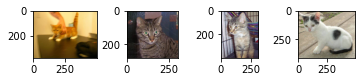

In [4]:
# Plot cat photos from the dogs vs cats dataset
plot_img(original_dataset_path, 'cat', 4)

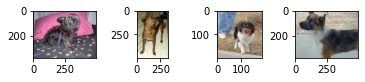

In [5]:
# Plot dog photos from the dogs vs cats dataset
plot_img(original_dataset_path, 'dog', 4)

## 2. Data preprocessing
Data should be formatted into appropriately preprocessed floating point tensors (or np array) before being fed into the network. We use the Keras image processing API to load all 25,000 images from the training dataset and reshapes them to 200×200 square images. The label is also determined for each images based on the filenames. This manier of preprocessing is optimal but it requires more RAM memory.

In [6]:
# # import load_img, img_to_array
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# # define location of dataset
# images = [] 
# labels = []
# # enumerate files in the directory
# for file in os.listdir(original_dataset_path):
#     # determine class
#     output = 0.0
#     if file.startswith('dog'):
#         output = 1.0
#     # load image
#     img = load_img(original_dataset_path + file, target_size=(200, 200))
#     # convert to numpy array
#     img = img_to_array(img)
#     # store
#     images.append(img)
#     labels.append(output)
# # convert to a numpy arrays
# images = np.asarray(images)
# labels = np.asarray(labels)
# print(images.shape, labels.shape)
# # save the reshaped images
# np.save('datasets/dogs_vs_cats_images.npy', images)
# np.save('datasets/dogs_vs_cats_labels.npy', labels)

Alternately, we can load the images progressively using the Keras ImageDataGenerator class and flow_from_directory() API. This will be slower to execute but will run on more machines.

This API prefers data to be divided into separate <code>train/</code> and <code>test/</code> directories, and under each directory to have a subdirectory for each class, e.g. a <code>train/dog/</code> and a <code>train/cat/</code> subdirectories and the same for test. Images are then organized under the subdirectories.

For this task we going to create directories in Python using the <code>makedirs()</code> function and use a loop to create the <code>dog/</code> and <code>cat/</code> subdirectories for both the <code>train/</code> and <code>test/</code> directories.

In [7]:
# create directories
dataset_path = 'datasets/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_path + subdir + labldir
        os.makedirs(newdir, exist_ok=True)

We can randomly decide to hold back 25% of the images into the test dataset

In [8]:
# import random
import random
random.seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy images from  original_dataset_path into subdirectories
for file in os.listdir(original_dataset_path):
    src = original_dataset_path + '/' + file
    dst_dir = 'train/'
    if random.random() < val_ratio:
        dst_dir = 'test/'
    if file.startswith('cat'):
        dst = dataset_path + dst_dir + 'cats/'  + file
        shutil.copyfile(src, dst)
    elif file.startswith('dog'):
        dst = dataset_path + dst_dir + 'dogs/'  + file
        shutil.copyfile(src, dst)

## 3. Define the model
Here we are going to build a model that accepts an image of dog_vs_cat as input. The output layer returns the network's predicted a binary class.

In [9]:
# import librairies
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 67712)             0

In [10]:
# import optimizers
from keras.optimizers import SGD
opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

## 4. Data preprocessing II
As on this machine we don't have enough RAM memory to use the optimal preprocessing type, we are going to use ImageDataGenerator.

In [11]:
# import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
# create data generator
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# prepare generators
train_generator = train_datagen.flow_from_directory('datasets/train/',
                                       class_mode='binary', 
                                       batch_size=64, 
                                       target_size=(200, 200))
test_generator = test_datagen.flow_from_directory('datasets/test/',
                                             class_mode='binary',
                                             batch_size=64, 
                                             target_size=(200, 200))


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


## 5. Train the model


In [12]:
hist = model.fit(train_generator, 
                              steps_per_epoch=len(train_generator),
                              validation_data=test_generator, 
                              validation_steps=len(test_generator), 
                              epochs=20, 
                              verbose=0)

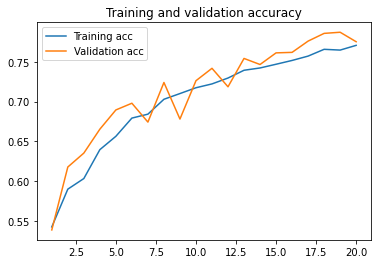

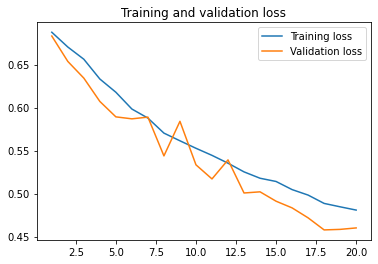

In [14]:
# Plot the loss and accuracy of the model over the training and validation data during training 
acc1 = hist.history['accuracy']
val_acc1 = hist.history['val_accuracy']
loss1 = hist.history['loss']
val_loss1 = hist.history['val_loss']

epochs = range(1, len(acc1) + 1)
plt.plot(epochs, acc1, label='Training acc')
plt.plot(epochs, val_acc1, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss1, label='Training loss')
plt.plot(epochs, val_loss1, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 6. Transfert Learning
Transfer learning involves using models trained on one problem as a starting point on a related problem. It is flexible, allowing the use of pre-trained models directly, as feature extraction preprocessing, and integrated into entirely new models

In [15]:
# import the VGG-16 convolution layers
from keras.applications import VGG16
# import Model 
from keras.models import Model
base_conv = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224, 224, 3))
# set the traainable attribut of base_conv to False because it won't be trained
base_conv.trainable = False
# define a Sequential model

flat1 = Flatten()(base_conv.output)
class1 = Dense(128, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)
model = Model(base_conv.input, output)

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [17]:
datagen = ImageDataGenerator(rescale=1.0/255)

# prepare generators
train_generator = datagen.flow_from_directory('datasets/train/',
                                       class_mode='binary', 
                                       batch_size=64, 
                                       target_size=(224, 224))
test_generator = datagen.flow_from_directory('datasets/test/',
                                             class_mode='binary',
                                             batch_size=64, 
                                             target_size=(224, 224))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In [18]:
hist = model.fit(train_generator, 
                              steps_per_epoch=len(train_generator),
                              validation_data=test_generator, 
                              validation_steps=len(test_generator), 
                              epochs=20, 
                              verbose=0)

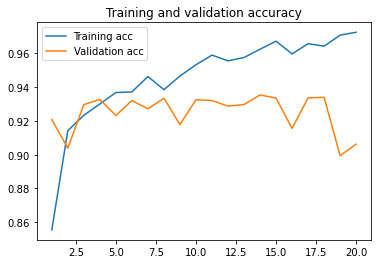

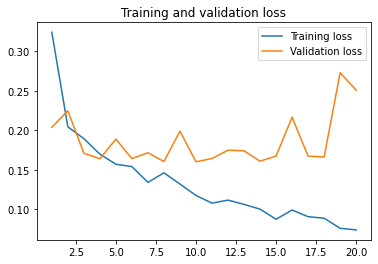

In [19]:
# Plot the loss and accuracy of the model over the training and validation data during training 
acc2 = hist.history['accuracy']
val_acc2 = hist.history['val_accuracy']
loss2 = hist.history['loss']
val_loss2 = hist.history['val_loss']

epochs = range(1, len(acc2) + 1)
plt.plot(epochs, acc2, label='Training acc')
plt.plot(epochs, val_acc2, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss2, label='Training loss')
plt.plot(epochs, val_loss2, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()